In [98]:
#!/usr/bin/python3

import sys

if sys.version_info[0] < 3:
    sys.exit("ERROR: Python version 3+ is required.")

import json, subprocess, io, os
from lxml import etree
from PIL import Image, ImageDraw, ImageOps

class PDF_Image_Compare:

    @staticmethod
    def compute_changes(pdf_fn_1, pdf_fn_2, top_margin=0, bottom_margin=100):
        # Serialize the text in the two PDFs.
        docs = [PDF_Image_Compare.serialize_pdf(0, pdf_fn_1, top_margin, bottom_margin), PDF_Image_Compare.serialize_pdf(1, pdf_fn_2, top_margin, bottom_margin)]

        # Compute differences between the serialized text.
        diff = PDF_Image_Compare.perform_diff(docs[0][1], docs[1][1])
        changes = PDF_Image_Compare.process_hunks(diff, [docs[0][0], docs[1][0]])
        changes = PDF_Image_Compare.simplify_changes(changes)
        
        return changes
    
    @staticmethod
    def serialize_pdf(i, fn, top_margin, bottom_margin):
        box_generator = PDF_Image_Compare.pdf_to_bboxes(i, fn, top_margin, bottom_margin)
        box_generator = PDF_Image_Compare.mark_eol_hyphens(box_generator)

        boxes = []
        text = []
        textlength = 0
        for run in box_generator:
            if run["text"] is None:
                continue

            normalized_text = run["text"].strip()

            # Ensure that each run ends with a space, since pdftotext
            # strips spaces between words. If we do a word-by-word diff,
            # that would be important.
            #
            # But don't put in a space if the box ends in a discretionary
            # hyphen. Instead, remove the hyphen.
            if normalized_text.endswith("\u00AD"):
                normalized_text = normalized_text[0:-1]
            else:
                normalized_text += " "

            run["text"] = normalized_text
            run["startIndex"] = textlength
            run["textLength"] = len(normalized_text)
            boxes.append(run)
            text.append(normalized_text)
            textlength += len(normalized_text)

        text = "".join(text)
        return boxes, text
    @staticmethod    
    def pdf_to_bboxes(pdf_index, fn, top_margin=0, bottom_margin=100):
        # Get the bounding boxes of text runs in the PDF.
        # Each text run is returned as a dict.
        box_index = 0
        pdfdict = {
            "index": pdf_index,
            "file": fn,
        }
        xml = subprocess.check_output(["pdftotext", "-bbox", fn, "-"])

        # This avoids PCDATA errors
        codes_to_avoid = [ 0, 1, 2, 3, 4, 5, 6, 7, 8,
                           11, 12,
                           14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, ]

        cleaned_xml = bytes([x for x in xml if x not in codes_to_avoid])

        dom = etree.fromstring(cleaned_xml)
        for i, page in enumerate(dom.findall(".//{http://www.w3.org/1999/xhtml}page")):
            pagedict = {
                "number": i+1,
                "width": float(page.get("width")),
                "height": float(page.get("height"))
            }
            for word in page.findall("{http://www.w3.org/1999/xhtml}word"):
                if float(word.get("yMax")) < (top_margin/100.0)*float(page.get("height")):
                    continue
                if float(word.get("yMin")) > (bottom_margin/100.0)*float(page.get("height")):
                    continue

                yield {
                    "index": box_index,
                    "pdf": pdfdict,
                    "page": pagedict,
                    "x": float(word.get("xMin")),
                    "y": float(word.get("yMin")),
                    "width": float(word.get("xMax"))-float(word.get("xMin")),
                    "height": float(word.get("yMax"))-float(word.get("yMin")),
                    "text": word.text,
                    }
                box_index += 1

    @staticmethod
    def mark_eol_hyphens(boxes):
        # Replace end-of-line hyphens with discretionary hyphens so we can weed
        # those out later. Finding the end of a line is hard.
        box = None
        for next_box in boxes:
            if box is not None:
                if box['pdf'] != next_box['pdf'] or box['page'] != next_box['page'] \
                    or next_box['y'] >= box['y'] + box['height']/2:
                    # box was at the end of a line
                    PDF_Image_Compare.mark_eol_hyphen(box)
                yield box
            box = next_box
        if box is not None:
            # The last box is at the end of a line too.
            PDF_Image_Compare.mark_eol_hyphen(box)
            yield box

    @staticmethod
    def mark_eol_hyphen(box):
        if box['text'] is not None:
            if box['text'].endswith("-"):
                box['text'] = box['text'][0:-1] + "\u00AD"

    @staticmethod
    def perform_diff(doc1text, doc2text):
        import diff_match_patch
        return diff_match_patch.diff(
            doc1text,
            doc2text,
            timelimit=0,
            checklines=False)

    @staticmethod
    def process_hunks(hunks, boxes):
        # Process each diff hunk one by one and look at their corresponding
        # text boxes in the original PDFs.
        offsets = [0, 0]
        changes = []
        for op, oplen in hunks:
            if op == "=":
                # This hunk represents a region in the two text documents that are
                # in common. So nothing to process but advance the counters.
                offsets[0] += oplen;
                offsets[1] += oplen;

                # Put a marker in the changes so we can line up equivalent parts
                # later.
                if len(changes) > 0 and changes[-1] != '*':
                    changes.append("*");

            elif op in ("-", "+"):
                # This hunk represents a region of text only in the left (op == "-")
                # or right (op == "+") document. The change is oplen chars long.
                idx = 0 if (op == "-") else 1

                PDF_Image_Compare.mark_difference(oplen, offsets[idx], boxes[idx], changes)

                offsets[idx] += oplen

                # Although the text doesn't exist in the other document, we want to
                # mark the position where that text may have been to indicate an
                # insertion.
                idx2 = 1 - idx
                PDF_Image_Compare.mark_difference(1, offsets[idx2]-1, boxes[idx2], changes)
                PDF_Image_Compare.mark_difference(0, offsets[idx2]+0, boxes[idx2], changes)

            else:
                raise ValueError(op)

        # Remove any final asterisk.
        if len(changes) > 0 and changes[-1] == "*":
            changes.pop()

        return changes

    @staticmethod
    def mark_difference(hunk_length, offset, boxes, changes):
      # We're passed an offset and length into a document given to us
      # by the text comparison, and we'll mark the text boxes passed
      # in boxes as having changed content.

      # Discard boxes whose text is entirely before this hunk
      while len(boxes) > 0 and (boxes[0]["startIndex"] + boxes[0]["textLength"]) <= offset:
        boxes.pop(0)

      # Process the boxes that intersect this hunk. We can't subdivide boxes,
      # so even though not all of the text in the box might be changed we'll
      # mark the whole box as changed.
      while len(boxes) > 0 and boxes[0]["startIndex"] < offset + hunk_length:
        # Mark this box as changed. Discard the box. Now that we know it's changed,
        # there's no reason to hold onto it. It can't be marked as changed twice.
        changes.append(boxes.pop(0))

    @staticmethod
    def simplify_changes(boxes):
        # Combine changed boxes when they were sequential in the input.
        # Our bounding boxes may be on a word-by-word basis, which means
        # neighboring boxes will lead to discontiguous rectangles even
        # though they are probably the same semantic change.
        changes = []
        for b in boxes:
            if len(changes) > 0 and changes[-1] != "*" and b != "*" \
                and changes[-1]["pdf"] == b["pdf"] \
                and changes[-1]["page"] == b["page"] \
                and changes[-1]["index"]+1 == b["index"] \
                and changes[-1]["y"] == b["y"] \
                and changes[-1]["height"] == b["height"]:
                changes[-1]["width"] = b["x"]+b["width"] - changes[-1]["x"]
                changes[-1]["text"] += b["text"]
                changes[-1]["index"] += 1 # so that in the next iteration we can expand it again
                continue
            changes.append(b)
        return changes
    @staticmethod
    def make_pages_images(changes,width):
        pages = [{}, {}]
        for change in changes:
            if change == "*": continue # not handled yet
            pdf_index = change["pdf"]["index"]
            pdf_page = change["page"]["number"]
            if pdf_page not in pages[pdf_index]:
                pages[pdf_index][pdf_page] = PDF_Image_Compare.pdftopng(change["pdf"]["file"], pdf_page,width)
        return pages
    
            # Rasterizes a page of a PDF.
    @staticmethod
    def pdftopng(pdffile, pagenumber,width):
        pngbytes = subprocess.check_output(["pdftoppm", "-f", str(pagenumber), "-l", str(pagenumber), "-scale-to", str(width), "-png", pdffile])
        im = Image.open(io.BytesIO(pngbytes))
        return im.convert("RGBA")
    
    @staticmethod
    def draw_red_boxes(changes, pages, styles):
        # Draw red boxes around changes.

        for change in changes:
            if change == "*": continue # not handled yet

            # 'box', 'strike', 'underline'
            style = styles[change["pdf"]["index"]]

            # the Image of the page
            im = pages[change["pdf"]["index"]][change["page"]]

            # draw it
            draw = ImageDraw.Draw(im)

            if style == "box":
                draw.rectangle((
                    change["x"], change["y"],
                    (change["x"]+change["width"]), (change["y"]+change["height"]),
                    ), outline="red")
            elif style == "strike":
                draw.line((
                    change["x"], change["y"]+change["height"]/2,
                    change["x"]+change["width"], change["y"]+change["height"]/2
                    ), fill="red")
            elif style == "underline":
                draw.line((
                    change["x"], change["y"]+change["height"],
                    change["x"]+change["width"], change["y"]+change["height"]
                    ), fill="red")

            del draw

In [99]:
compare=PDF_Image_Compare()

In [100]:
changes = compare.compute_changes('document-pages-1-10.pdf','document2-pages-1-10.pdf', top_margin=float(0), bottom_margin=float(100))

In [101]:
pages = compare.make_pages_images(changes,1900)

In [107]:
for change in changes:
    print(change)

{'index': 9, 'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'}, 'page': {'number': 1, 'width': 612.0, 'height': 792.0}, 'x': 258.840076, 'y': 68.770453, 'width': 49.62477000000001, 'height': 9.240023999999991, 'text': 'Washington, ', 'startIndex': 67, 'textLength': 12}
{'index': 9, 'pdf': {'index': 1, 'file': 'document2-pages-1-10.pdf'}, 'page': {'number': 1, 'width': 612.0, 'height': 792.0}, 'x': 244.215099, 'y': 54.996391, 'width': 67.28549699999996, 'height': 10.408541, 'text': 'WASHINGTON, ', 'startIndex': 67, 'textLength': 12}
*
{'index': 12, 'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'}, 'page': {'number': 1, 'width': 612.0, 'height': 792.0}, 'x': 258.621378, 'y': 78.313678, 'width': 91.81409500000001, 'height': 9.240024000000005, 'text': '____________________ ', 'startIndex': 90, 'textLength': 21}
{'index': 14, 'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'}, 'page': {'number': 1, 'width': 612.0, 'height': 792.0}, 'x': 269.695495, 'y': 89.611467, 'width': 71

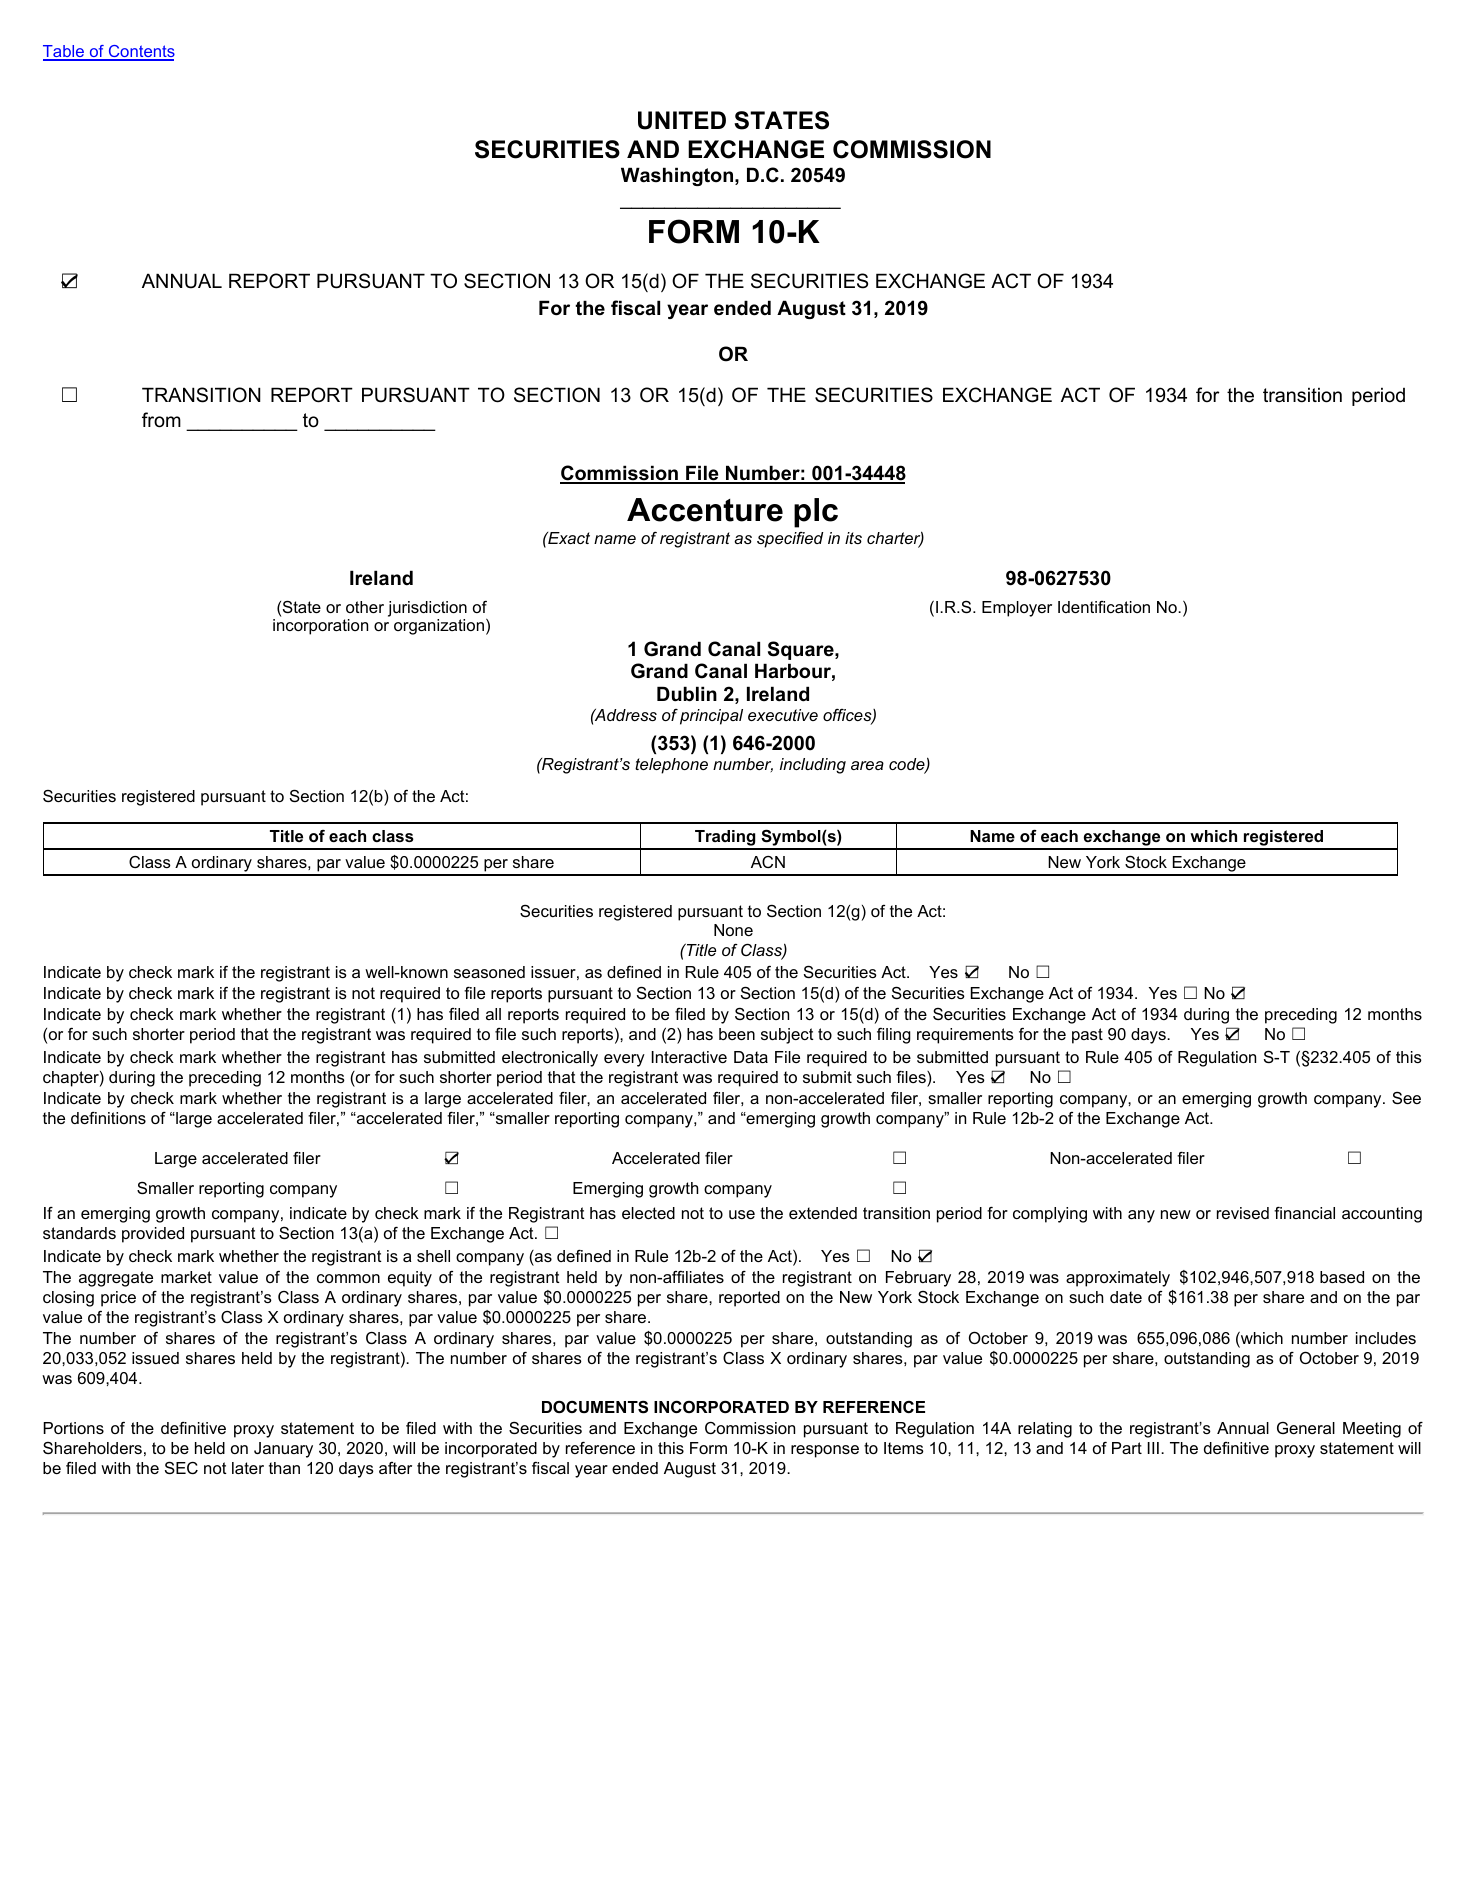

In [102]:
pages[change["pdf"]["index"]][change["page"]]

In [96]:
# Convert the box coordinates (PDF coordinates) into image coordinates.
# Then set change["page"] = change["page"]["number"] so that we don't
# share the page object between changes (since we'll be rewriting page
# numbers).
for change in changes:
    print(change)
    if change == "*": 
        continue
    im = pages[change["pdf"]["index"]][change["page"]["number"]]
    print(im)
    change["x"] *= im.size[0]/change["page"]["width"]
    change["y"] *= im.size[1]/change["page"]["height"]
    change["width"] *= im.size[0]/change["page"]["width"]
    change["height"] *= im.size[1]/change["page"]["height"]
    change["page"] = change["page"]["number"]

{'index': 9, 'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'}, 'page': 1, 'x': 621.3007706601308, 'y': 164.9796220959596, 'width': 119.11566524509806, 'height': 22.16672424242422, 'text': 'Washington, ', 'startIndex': 67, 'textLength': 12}


TypeError: 'int' object is not subscriptable

In [94]:
changes

[{'index': 9,
  'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'},
  'page': 1,
  'x': 621.3007706601308,
  'y': 164.9796220959596,
  'width': 119.11566524509806,
  'height': 22.16672424242422,
  'text': 'Washington, ',
  'startIndex': 67,
  'textLength': 12},
 {'index': 9,
  'pdf': {'index': 1, 'file': 'document2-pages-1-10.pdf'},
  'page': 1,
  'x': 586.1960464558823,
  'y': 131.935786489899,
  'width': 161.50718152450972,
  'height': 24.969984722222218,
  'text': 'WASHINGTON, ',
  'startIndex': 67,
  'textLength': 12},
 '*',
 {'index': 12,
  'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'},
  'page': 1,
  'x': 620.775823990196,
  'y': 187.87372247474744,
  'width': 220.38383260620915,
  'height': 22.16672424242425,
  'text': '____________________ ',
  'startIndex': 90,
  'textLength': 21},
 {'index': 14,
  'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'},
  'page': 1,
  'x': 647.3573237826797,
  'y': 214.97700416666666,
  'width': 172.8143049558823,
  'height': 35.8

In [77]:
changes[12]

{'index': 39,
 'pdf': {'index': 1, 'file': 'document2-pages-1-10.pdf'},
 'page': {'number': 1, 'width': 612.0, 'height': 792.0},
 'x': 366.684889,
 'y': 109.536926,
 'width': 17.933482000000026,
 'height': 9.020735000000002,
 'text': '2018 ',
 'startIndex': 235,
 'textLength': 5}

In [78]:
for change in changes:
    print(change)

{'index': 9, 'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'}, 'page': {'number': 1, 'width': 612.0, 'height': 792.0}, 'x': 258.840076, 'y': 68.770453, 'width': 49.62477000000001, 'height': 9.240023999999991, 'text': 'Washington, ', 'startIndex': 67, 'textLength': 12}
{'index': 9, 'pdf': {'index': 1, 'file': 'document2-pages-1-10.pdf'}, 'page': {'number': 1, 'width': 612.0, 'height': 792.0}, 'x': 244.215099, 'y': 54.996391, 'width': 67.28549699999996, 'height': 10.408541, 'text': 'WASHINGTON, ', 'startIndex': 67, 'textLength': 12}
*
{'index': 12, 'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'}, 'page': {'number': 1, 'width': 612.0, 'height': 792.0}, 'x': 258.621378, 'y': 78.313678, 'width': 91.81409500000001, 'height': 9.240024000000005, 'text': '____________________ ', 'startIndex': 90, 'textLength': 21}
{'index': 14, 'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'}, 'page': {'number': 1, 'width': 612.0, 'height': 792.0}, 'x': 269.695495, 'y': 89.611467, 'width': 71

In [48]:
img = compare.render_changes(changes, ['strike', 'underline'], 1900)

[{'index': 9, 'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'}, 'page': {'number': 1, 'width': 612.0, 'height': 792.0}, 'x': 258.840076, 'y': 68.770453, 'width': 49.62477000000001, 'height': 9.240023999999991, 'text': 'Washington, ', 'startIndex': 67, 'textLength': 12}, {'index': 9, 'pdf': {'index': 1, 'file': 'document2-pages-1-10.pdf'}, 'page': {'number': 1, 'width': 612.0, 'height': 792.0}, 'x': 244.215099, 'y': 54.996391, 'width': 67.28549699999996, 'height': 10.408541, 'text': 'WASHINGTON, ', 'startIndex': 67, 'textLength': 12}, '*', {'index': 12, 'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'}, 'page': {'number': 1, 'width': 612.0, 'height': 792.0}, 'x': 258.621378, 'y': 78.313678, 'width': 91.81409500000001, 'height': 9.240024000000005, 'text': '____________________ ', 'startIndex': 90, 'textLength': 21}, {'index': 14, 'pdf': {'index': 0, 'file': 'document-pages-1-10.pdf'}, 'page': {'number': 1, 'width': 612.0, 'height': 792.0}, 'x': 269.695495, 'y': 89.611467, 'wid

[{1: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB5046FD0>, 2: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB50B4470>, 3: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB4EEC128>, 4: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB4F1D908>, 5: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8ABFDBC0F0>, 6: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB5176908>, 7: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB531C7B8>, 8: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB4A19320>, 9: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB4A194E0>, 10: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB4DD1048>}, {1: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB51AA320>, 2: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB50B4C88>, 3: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB4F15780>, 4: <PIL.Image.Image image mode=RGBA size=1469x1900 at 0x7F8AB4F1DE48>, 5

In [7]:
img.save('diff.png')